# 04 - Teknoloji ve ROI Analizi

Bu dosya, 2025 Yazilim Sektoru Maas Anketi icin özel teknoloji analizi ve ROI hesaplamalarina odaklanmaktadir

## Hedefler:
- Teknoloji yigini analizine derinlemesine dalmak
- Teknolojiler icin ayrintili ROI metriklerini hesaplamak
- Teknoloji icgorulerine yonelik ozel gorsellestirmeler olusturmak
- Calisma duzeni ve konum etkilesimlerini analiz etmek

## Kütüphaneleri İçe Aktarın ve Verileri Yükleyin

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")

# Constants
FIG_DIR = '../figures'
LOCATION_NOTE = 'Note: Estimated location is inferred from company location and work mode (Office/Hybrid → company location). Not definitive.'

# Load processed data
df = pd.read_pickle('../data/processed_dataframe.pkl')
print(f'Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns')

Dataset loaded: 2969 rows, 94 columns


## Rol Bazında Çalışma Düzeni Dağılımı

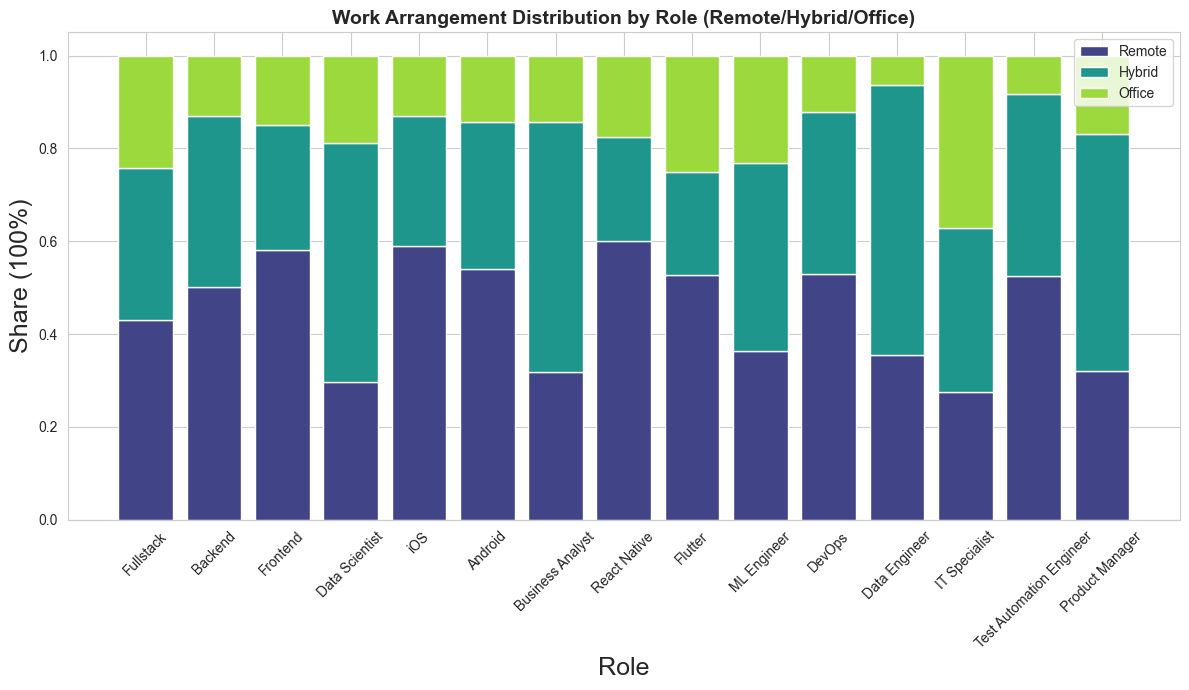

Work Arrangement Distribution by Role:


,Role,Total Count,Remote Share,Hybrid Share,Office Share
11,Fullstack,790,0.429,0.329,0.242
1,Backend,517,0.501,0.369,0.130
10,Frontend,397,0.582,0.270,0.149
6,Data Scientist,101,0.297,0.515,0.188
23,iOS,100,0.590,0.280,0.130
0,Android,98,0.541,0.316,0.143
2,Business Analyst,91,0.319,0.538,0.143
19,React Native,85,0.600,0.224,0.176
9,Flutter,72,0.528,0.222,0.250
14,ML Engineer,69,0.362,0.406,0.232


In [36]:
# 100% stacked bar: work mode shares per top roles
role_cols = [c for c in df.columns if c.startswith('role_')]
modes = [m for m in ['Remote', 'Hybrid', 'Office'] if f'work_mode_{m}' in df.columns]

if role_cols and modes:
    def pick_role(row):
        for c in role_cols:
            if row.get(c, 0) == 1:
                return c.replace('role_', '').replace('_', ' ')
        return ''
    
    tmp = df.copy()
    tmp['role_primary'] = tmp.apply(pick_role, axis=1)
    tmp = tmp[tmp['role_primary'] != '']
    
    if not tmp.empty:
        agg = []
        for role, g in tmp.groupby('role_primary'):
            counts = {m: int((g[f'work_mode_{m}'] == 1).sum()) for m in modes}
            total = sum(counts.values())
            if total >= 20:
                shares = {m: (counts[m] / total) for m in modes}
                shares['role'] = role
                shares['n'] = total
                agg.append(shares)
        
        if agg:
            share_df = pd.DataFrame(agg).sort_values('n', ascending=False).head(15)
            roles = share_df['role'].tolist()
            bottoms = np.zeros(len(roles))
            
            plt.figure(figsize=(12, 7))
            cmap = plt.get_cmap('viridis')
            mode_colors = {m: cmap(v) for m, v in zip(modes, np.linspace(0.2, 0.85, len(modes)))}
            
            for m in modes:
                vals = share_df[m].values
                plt.bar(roles, vals, bottom=bottoms, label=m, color=mode_colors[m])
                bottoms += vals
            
            plt.xticks(rotation=45)
            plt.ylabel('Share (100%)', fontsize=18)
            plt.xlabel('Role', fontsize=18)
            plt.title('Work Arrangement Distribution by Role (Remote/Hybrid/Office)', fontsize=14, fontweight='bold')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, 'barplot_work_arrangement_by_role.png'), dpi=300, bbox_inches='tight')
            plt.show()
            
            # Display work arrangement summary
            work_arrangement_summary = share_df[['role', 'n'] + modes].round(3)
            work_arrangement_summary.columns = ['Role', 'Total Count'] + [f'{mode} Share' for mode in modes]
            print("Work Arrangement Distribution by Role:")
            display(work_arrangement_summary)

## Rol Analizine Göre Araçların Benimsenmesi

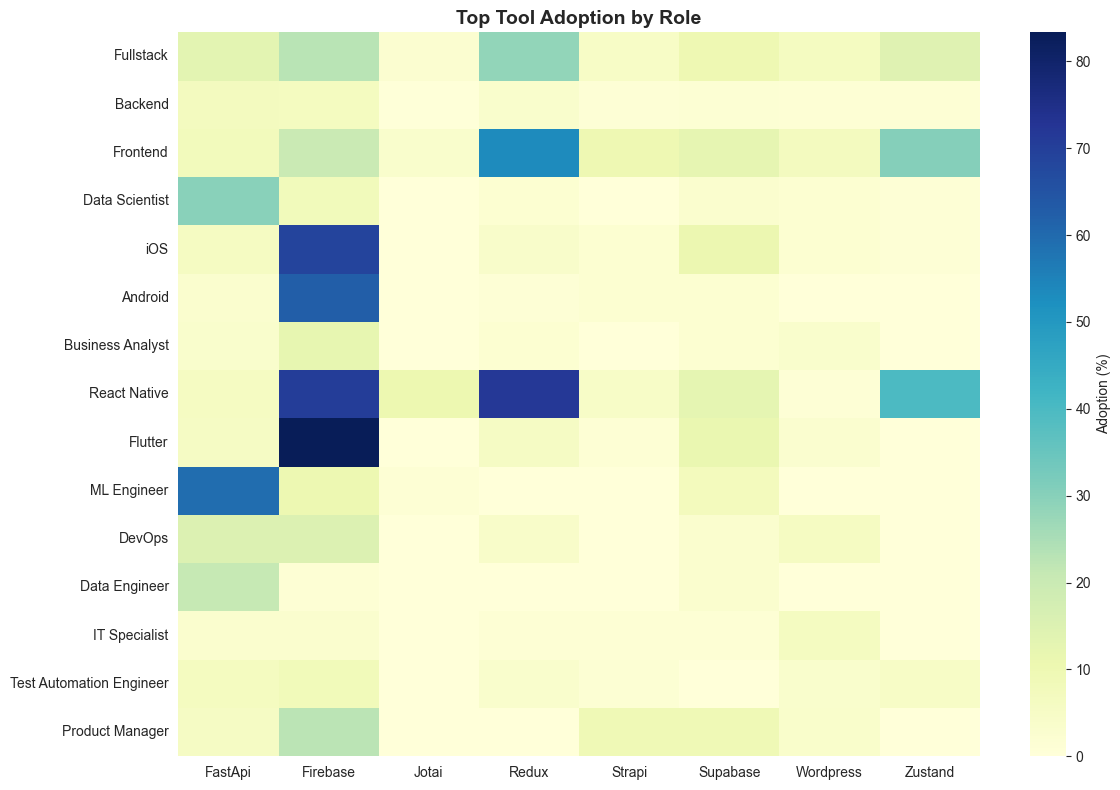

Tool Adoption by Role (Top 15 roles - Graph):


,FastApi,Firebase,Jotai,Redux,Strapi,Supabase,Wordpress,Zustand
Fullstack,13.3,22.9,2.4,28.6,5.1,9.9,6.3,14.6
Backend,7.2,6.6,0.6,3.5,1.2,1.7,1.5,1.4
Frontend,7.8,19.9,3.5,53.1,9.8,12.6,7.1,30.5
Data Scientist,29.7,7.9,0.0,2.0,0.0,3.0,2.0,1.0
iOS,6.0,69.0,0.0,4.0,2.0,11.0,2.0,1.0
Android,3.1,62.2,0.0,1.0,2.0,2.0,0.0,0.0
Business Analyst,3.3,12.1,0.0,2.2,0.0,2.2,3.3,0.0
React Native,5.9,70.6,10.6,71.8,4.7,12.9,1.2,40.0
Flutter,5.6,83.3,0.0,5.6,1.4,11.1,2.8,0.0
ML Engineer,59.4,10.1,1.4,0.0,0.0,7.2,0.0,0.0



Tool Adoption by Role (All roles):


,FastApi,Firebase,Jotai,Redux,Strapi,Supabase,Wordpress,Zustand
Fullstack,13.3,22.9,2.4,28.6,5.1,9.9,6.3,14.6
Backend,7.2,6.6,0.6,3.5,1.2,1.7,1.5,1.4
Frontend,7.8,19.9,3.5,53.1,9.8,12.6,7.1,30.5
Data Scientist,29.7,7.9,0.0,2.0,0.0,3.0,2.0,1.0
iOS,6.0,69.0,0.0,4.0,2.0,11.0,2.0,1.0
Android,3.1,62.2,0.0,1.0,2.0,2.0,0.0,0.0
Business Analyst,3.3,12.1,0.0,2.2,0.0,2.2,3.3,0.0
React Native,5.9,70.6,10.6,71.8,4.7,12.9,1.2,40.0
Flutter,5.6,83.3,0.0,5.6,1.4,11.1,2.8,0.0
ML Engineer,59.4,10.1,1.4,0.0,0.0,7.2,0.0,0.0


In [37]:
# Heatmap of tool adoption percentages between roles
role_cols = [c for c in df.columns if c.startswith('role_')]
tool_cols = [c for c in df.columns if c.startswith('tools_') and not c.endswith('Kullanmiyorum')]

if role_cols and tool_cols:
    def pick_role(row):
        for c in role_cols:
            if row.get(c, 0) == 1:
                return c.replace('role_', '').replace('_', ' ')
        return ''
    
    tmp = df.copy()
    tmp['role_primary'] = tmp.apply(pick_role, axis=1)
    tmp = tmp[tmp['role_primary'] != '']
    
    if not tmp.empty:
        role_counts = tmp['role_primary'].value_counts()
        popular_roles = role_counts[role_counts >= 20].index.tolist()[:15]
        
        if popular_roles:
            mat = []
            for role in popular_roles:
                g = tmp[tmp['role_primary'] == role]
                vals = [g[c].mean() * 100 for c in tool_cols]
                mat.append(vals)
            
            heat = np.array(mat)
            col_labels = [c.replace('tools_', '').replace('_', ' ') for c in tool_cols]
            
            plt.figure(figsize=(max(12, len(tool_cols) * 0.4), 8))
            sns.heatmap(heat, annot=False, cmap='YlGnBu', yticklabels=popular_roles, 
                       xticklabels=col_labels, cbar_kws={'label': 'Adoption (%)'})
            plt.title('Top Tool Adoption by Role', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, 'heatmap_tool_adoption_by_role.png'), dpi=300, bbox_inches='tight')
            plt.show()
            
            # Display tool adoption summary for top 15 roles
            tool_adoption_df = pd.DataFrame(heat, index=popular_roles, columns=col_labels).round(1)
            print("Tool Adoption by Role (Top 15 roles - Graph):")
            display(tool_adoption_df)
            
            # Display all roles
            all_roles = role_counts[role_counts >= 20].index.tolist()
            all_mat = []
            for role in all_roles:
                g = tmp[tmp['role_primary'] == role]
                vals = [g[c].mean() * 100 for c in tool_cols]
                all_mat.append(vals)
            
            all_heat = np.array(all_mat)
            all_tool_adoption_df = pd.DataFrame(all_heat, index=all_roles, columns=col_labels).round(1)
            print("\nTool Adoption by Role (All roles):")
            display(all_tool_adoption_df)

## İş Türü × Şirket Konumu Analizi

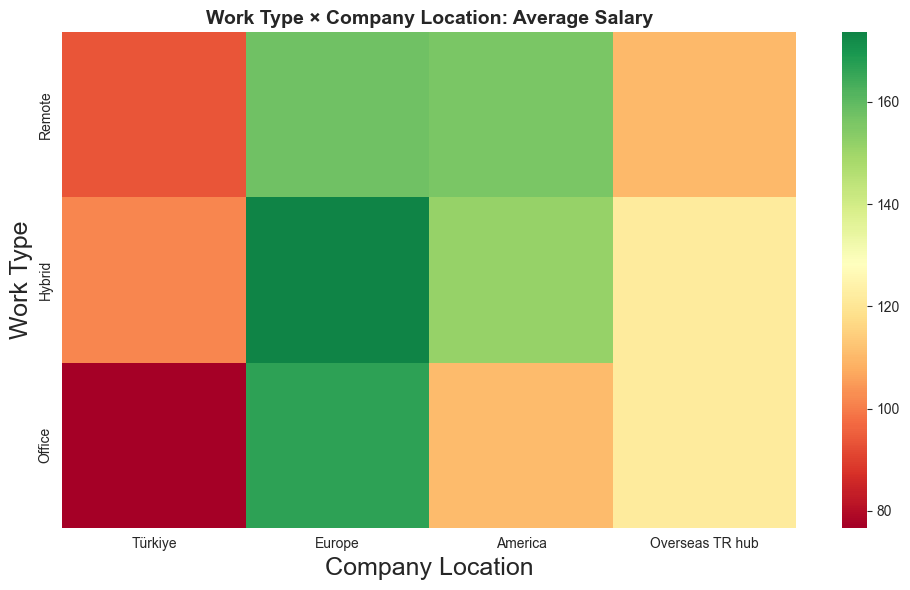

Average Salary by Work Type and Company Location:


,Türkiye,Europe,America,Overseas TR hub
Remote,93.4,157.4,156.0,110.1
Hybrid,101.6,173.6,151.3,121.5
Office,76.7,166.6,110.5,121.5


In [38]:
# Heatmap of average salaries by work type and company location
modes = [m for m in ['Remote', 'Hybrid', 'Office'] if f'work_mode_{m}' in df.columns]
locs = [l for l in ['Turkiye', 'Avrupa', 'Amerika', 'Yurtdisi_TR_hub'] if f'company_location_{l}' in df.columns]

if modes and locs:
    avg_mat = np.full((len(modes), len(locs)), np.nan)
    
    for i, m in enumerate(modes):
        for j, l in enumerate(locs):
            s = df[(df[f'work_mode_{m}'] == 1) & (df[f'company_location_{l}'] == 1)]['salary_numeric']
            if len(s) > 0:
                avg_mat[i, j] = s.mean()
    
    if not np.isnan(avg_mat).all():
        plt.figure(figsize=(10, 6))
        loc_labels = ['Türkiye', 'Europe', 'America', 'Overseas TR hub'][:len(locs)]
        sns.heatmap(avg_mat, annot=False, cmap='RdYlGn', center=np.nanmean(avg_mat), 
                   yticklabels=modes, xticklabels=loc_labels)
        plt.title('Work Type × Company Location: Average Salary', fontsize=14, fontweight='bold')
        plt.xlabel('Company Location', fontsize=18)
        plt.ylabel('Work Type', fontsize=18)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'heatmap_worktype_location_salary.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display work type × location summary
        work_location_df = pd.DataFrame(avg_mat, index=modes, columns=loc_labels).round(1)
        print("Average Salary by Work Type and Company Location:")
        display(work_location_df)

## Beceri Çeşitliliği Analizi

/var/folders/ht/96dlk6450fq3bpq3xm8nnnb00000gn/T/ipykernel_60245/3360786689.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby('skill_diversity_group')['skill_diversity_score']


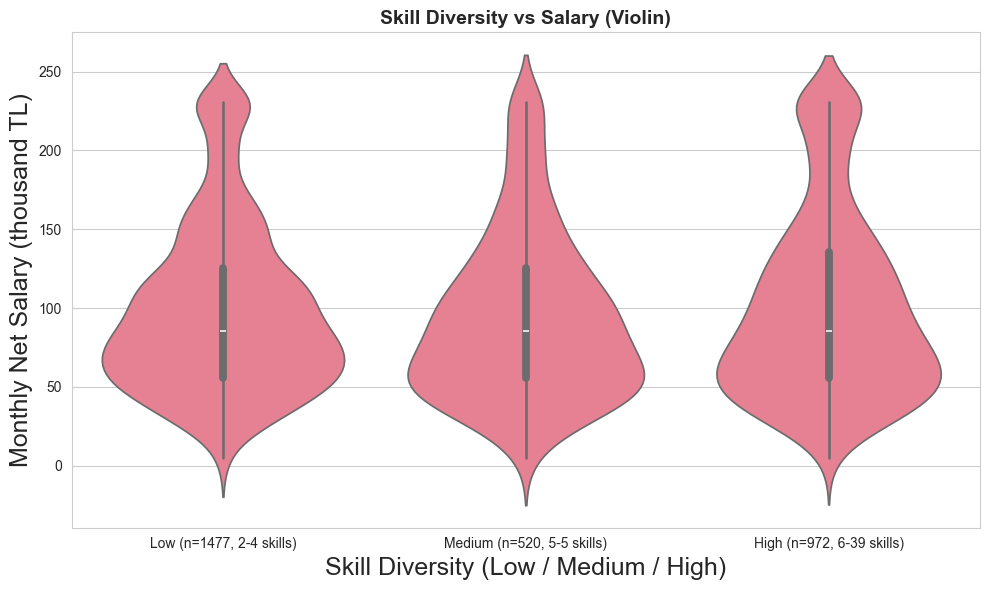

Salary Statistics by Skill Diversity:


,Count,Mean Salary,Std Dev
skill_diversity_group,,,
Low,1477,98.7,53.2
Medium,520,93.5,52.5
High,972,99.9,58.6


In [39]:
# Violin plot: salary distribution by skill diversity groups
if 'skill_diversity_total' in df.columns:
    vals = df['skill_diversity_total']
else:
    prog_cols = [c for c in df.columns if c.startswith('programming_')]
    fe_cols = [c for c in df.columns if c.startswith('frontend_')]
    tool_cols = [c for c in df.columns if c.startswith('tools_')]
    
    if prog_cols or fe_cols or tool_cols:
        vals = df[prog_cols].sum(axis=1).fillna(0)
        if fe_cols:
            vals = vals + df[fe_cols].sum(axis=1).fillna(0)
        if tool_cols:
            vals = vals + df[tool_cols].sum(axis=1).fillna(0)
    else:
        vals = pd.Series([0] * len(df))

tmp = df.copy()
tmp['skill_diversity_score'] = vals

# Bin into tertiles (low/medium/high)
try:
    tmp['skill_diversity_group'] = pd.qcut(tmp['skill_diversity_score'], q=3, labels=['Low', 'Medium', 'High'])
except Exception:
    tmp['skill_diversity_group'] = pd.cut(tmp['skill_diversity_score'], bins=[-1, 2, 5, np.inf], labels=['Low', 'Medium', 'High'])

tmp = tmp.dropna(subset=['skill_diversity_group', 'salary_numeric'])

if not tmp.empty:
    plt.figure(figsize=(10, 6))
    labels_order = ['Low', 'Medium', 'High']
    
    # Compute counts and observed skill-count ranges per group
    counts = tmp['skill_diversity_group'].value_counts().reindex(labels_order).fillna(0).astype(int)
    ranges = (
        tmp.groupby('skill_diversity_group')['skill_diversity_score']
        .agg(['min', 'max'])
        .reindex(labels_order)
        .fillna(0)
        .astype({'min': int, 'max': int})
    )
    
    sns.violinplot(data=tmp, x='skill_diversity_group', y='salary_numeric', inner='box', 
                   order=labels_order)
    plt.xlabel('Skill Diversity (Low / Medium / High)', fontsize=18)
    plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=18)
    plt.title('Skill Diversity vs Salary (Violin)', fontsize=14, fontweight='bold')
    
    # Enrich x-tick labels with counts and skill ranges
    xtick_labels = [
        f"{lab} (n={counts[lab]}, {ranges.loc[lab, 'min']}-{ranges.loc[lab, 'max']} skills)" for lab in labels_order
    ]
    plt.xticks(ticks=range(len(labels_order)), labels=xtick_labels)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'violin_skill_diversity.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display skill diversity summary
    skill_diversity_summary = tmp.groupby('skill_diversity_group', observed=True)['salary_numeric'].agg(['count', 'mean', 'std']).round(1)
    skill_diversity_summary.columns = ['Count', 'Mean Salary', 'Std Dev']
    print("Salary Statistics by Skill Diversity:")
    display(skill_diversity_summary)

## Teknoloji Stack ROI Derinlemesine Inceleme

In [40]:
# Calculate comprehensive ROI for all technologies
def calculate_comprehensive_roi():
    """Calculate ROI for all technology categories"""
    roi_results = {}
    
    # Programming languages
    prog_cols = [c for c in df.columns if c.startswith('programming_') and c != 'programming_Hicbiri']
    prog_roi = []
    for col in prog_cols:
        users = df.loc[df[col] == 1, 'salary_numeric']
        non_users = df.loc[df[col] == 0, 'salary_numeric']
        if len(users) >= 10 and len(non_users) >= 10:
            roi = float(users.mean() - non_users.mean())
            roi_pct = (roi / non_users.mean()) * 100 if non_users.mean() > 0 else 0
            prog_roi.append({
                'Technology': col.replace('programming_', '').replace('_', ' '),
                'Category': 'Programming Language',
                'ROI (thousand TL)': roi,
                'ROI (%)': roi_pct,
                'User Count': len(users),
                'User Avg Salary': users.mean(),
                'Non-user Avg Salary': non_users.mean()
            })
    
    # Frontend technologies
    fe_cols = [c for c in df.columns if c.startswith('frontend_') and c != 'frontend_Kullanmiyorum']
    fe_roi = []
    for col in fe_cols:
        users = df.loc[df[col] == 1, 'salary_numeric']
        non_users = df.loc[df[col] == 0, 'salary_numeric']
        if len(users) >= 10 and len(non_users) >= 10:
            roi = float(users.mean() - non_users.mean())
            roi_pct = (roi / non_users.mean()) * 100 if non_users.mean() > 0 else 0
            fe_roi.append({
                'Technology': col.replace('frontend_', '').replace('_', ' '),
                'Category': 'Frontend Technology',
                'ROI (thousand TL)': roi,
                'ROI (%)': roi_pct,
                'User Count': len(users),
                'User Avg Salary': users.mean(),
                'Non-user Avg Salary': non_users.mean()
            })
    
    # Tools
    tool_cols = [c for c in df.columns if c.startswith('tools_') and not c.endswith('Kullanmiyorum')]
    tool_roi = []
    for col in tool_cols:
        users = df.loc[df[col] == 1, 'salary_numeric']
        non_users = df.loc[df[col] == 0, 'salary_numeric']
        if len(users) >= 10 and len(non_users) >= 10:
            roi = float(users.mean() - non_users.mean())
            roi_pct = (roi / non_users.mean()) * 100 if non_users.mean() > 0 else 0
            tool_roi.append({
                'Technology': col.replace('tools_', '').replace('_', ' '),
                'Category': 'Tool',
                'ROI (thousand TL)': roi,
                'ROI (%)': roi_pct,
                'User Count': len(users),
                'User Avg Salary': users.mean(),
                'Non-user Avg Salary': non_users.mean()
            })
    
    # Combine all results
    all_roi = prog_roi + fe_roi + tool_roi
    roi_df = pd.DataFrame(all_roi)
    
    return roi_df

# Calculate comprehensive ROI
comprehensive_roi = calculate_comprehensive_roi()

if not comprehensive_roi.empty:
    # Display top ROI technologies
    top_roi = comprehensive_roi.sort_values('ROI (thousand TL)', ascending=False).head(20)
    print("Top 20 Technologies by ROI (Graph):")
    display(top_roi.round(1))
    
    # Display all technologies
    all_roi_sorted = comprehensive_roi.sort_values('ROI (thousand TL)', ascending=False)
    print("\nAll Technologies by ROI:")
    display(all_roi_sorted.round(1))
    
    # Display ROI by category
    category_summary = comprehensive_roi.groupby('Category').agg({
        'ROI (thousand TL)': ['mean', 'std', 'count'],
        'ROI (%)': ['mean', 'std']
    }).round(1)
    print("\nROI Summary by Technology Category:")
    display(category_summary)

Top 20 Technologies by ROI (Graph):


,Technology,Category,ROI (thousand TL),ROI (%),User Count,User Avg Salary,Non-user Avg Salary
16,Rust,Programming Language,69.4,71.0,22,167.1,97.7
11,Objective C,Programming Language,63.1,64.8,39,160.5,97.4
15,Ruby,Programming Language,45.8,46.8,24,143.6,97.8
3,Cobol,Programming Language,45.4,46.3,22,143.2,97.9
5,Go,Programming Language,39.1,40.8,183,134.9,95.8
1,Bash,Programming Language,36.0,37.2,114,132.8,96.8
9,Kotlin,Programming Language,32.2,33.5,201,128.2,96.0
14,R Language,Programming Language,30.7,31.4,29,128.6,97.9
27,Jotai,Tool,28.8,29.4,50,126.5,97.7
18,Swift,Programming Language,21.8,22.5,197,118.6,96.8



All Technologies by ROI:


,Technology,Category,ROI (thousand TL),ROI (%),User Count,User Avg Salary,Non-user Avg Salary
16,Rust,Programming Language,69.4,71.0,22,167.1,97.7
11,Objective C,Programming Language,63.1,64.8,39,160.5,97.4
15,Ruby,Programming Language,45.8,46.8,24,143.6,97.8
3,Cobol,Programming Language,45.4,46.3,22,143.2,97.9
5,Go,Programming Language,39.1,40.8,183,134.9,95.8
1,Bash,Programming Language,36.0,37.2,114,132.8,96.8
9,Kotlin,Programming Language,32.2,33.5,201,128.2,96.0
14,R Language,Programming Language,30.7,31.4,29,128.6,97.9
27,Jotai,Tool,28.8,29.4,50,126.5,97.7
18,Swift,Programming Language,21.8,22.5,197,118.6,96.8



ROI Summary by Technology Category:


ROI (thousand TL)             ROI (%)      
                                  mean   std count    mean   std
Category                                                        
Frontend Technology                0.9   5.2     4     1.0   5.3
Programming Language              20.3  23.3    21    21.0  23.8
Tool                               2.8  11.7     8     2.9  11.9

## Teknoloji Kombinasyon Analizi

Top 10 Technology Combinations by Role (Graph):


,role,combo,avg_salary,count
190,React Native,JavaScript + React + Firebase,99.6,17
134,Fullstack,HTML CSS + React + Zustand,97.3,11
65,Frontend,HTML CSS + Angular + Redux,96.2,14
184,React Native,HTML CSS + React + Firebase,94.0,20
130,Fullstack,HTML CSS + React + Redux,91.1,70
73,Frontend,HTML CSS + React + Zustand,88.8,21
69,Frontend,HTML CSS + React + Redux,85.2,121
67,Frontend,HTML CSS + React + Firebase,82.9,50
128,Fullstack,HTML CSS + React + Firebase,82.4,45
125,Fullstack,HTML CSS + Angular + Redux,81.0,11



All Technology Combinations by Role:


,role,combo,avg_salary,count
190,React Native,JavaScript + React + Firebase,99.6,17
134,Fullstack,HTML CSS + React + Zustand,97.3,11
65,Frontend,HTML CSS + Angular + Redux,96.2,14
184,React Native,HTML CSS + React + Firebase,94.0,20
130,Fullstack,HTML CSS + React + Redux,91.1,70
73,Frontend,HTML CSS + React + Zustand,88.8,21
69,Frontend,HTML CSS + React + Redux,85.2,121
67,Frontend,HTML CSS + React + Firebase,82.9,50
128,Fullstack,HTML CSS + React + Firebase,82.4,45
125,Fullstack,HTML CSS + Angular + Redux,81.0,11


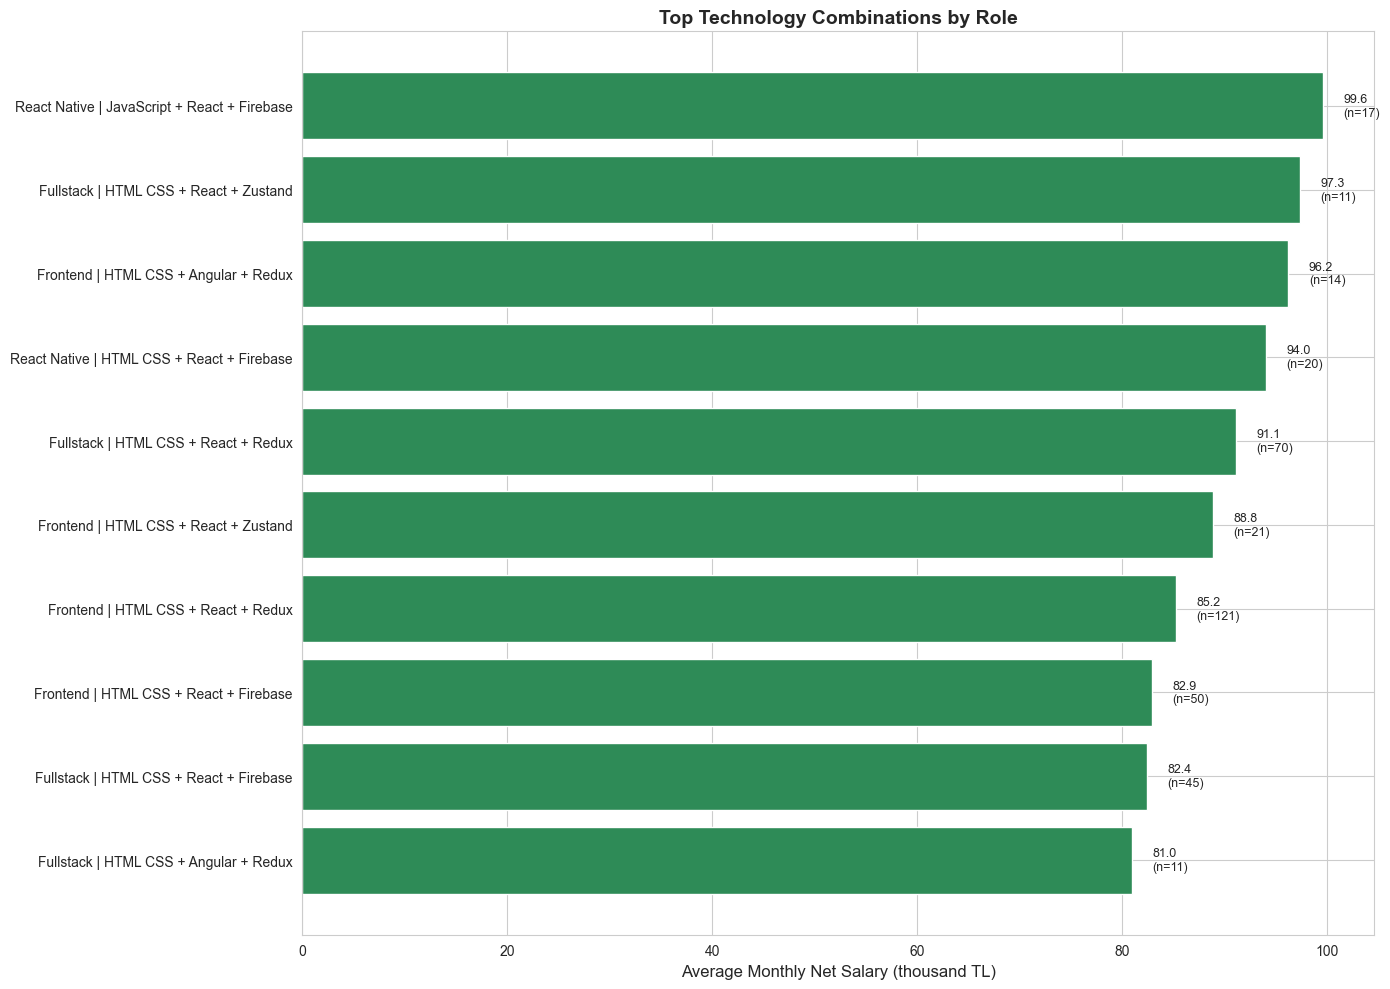

In [41]:
# Analyze technology combinations and their impact
def analyze_tech_combinations():
    """Analyze the impact of technology combinations (programming + frontend + tool) by role"""
    role_cols = [c for c in df.columns if c.startswith('role_')]
    prog_cols = [c for c in df.columns if c.startswith('programming_') and c != 'programming_Hicbiri']
    fe_cols = [c for c in df.columns if c.startswith('frontend_') and c != 'frontend_Kullanmiyorum']
    tool_cols = [c for c in df.columns if c.startswith('tools_') and not c.endswith('Kullanmiyorum')]
    
    if not role_cols or (not prog_cols and not fe_cols and not tool_cols):
        return pd.DataFrame()

    def pick_first_true(cols: list[str], row: pd.Series) -> str:
        for c in cols:
            try:
                if row[c] == 1:
                    return c
            except KeyError:
                continue
        return ''

    records = []
    for _, row in df.iterrows():
        role_c = pick_first_true(role_cols, row)
        if not role_c:
            continue
        role_name = role_c.replace('role_', '').replace('_', ' ')
        lang_c = pick_first_true(prog_cols, row)
        fe_c = pick_first_true(fe_cols, row)
        tool_c = pick_first_true(tool_cols, row)
        lang = lang_c.replace('programming_', '').replace('_', ' ') if lang_c else ''
        fe = fe_c.replace('frontend_', '').replace('_', ' ') if fe_c else ''
        tool = tool_c.replace('tools_', '').replace('_', ' ') if tool_c else ''
        # Skip records that include missing/none-like selections
        if lang in ['', 'None'] or fe in ['', 'None'] or tool in ['', 'None', 'Kullanmiyorum']:
            continue
        combo = f'{lang} + {fe} + {tool}'
        records.append((role_name, combo, row.get('salary_numeric', np.nan)))

    if not records:
        return pd.DataFrame()
    
    combos_df = pd.DataFrame(records, columns=['role', 'combo', 'salary'])
    combos_df = combos_df.dropna(subset=['salary'])
    grouped = combos_df.groupby(['role', 'combo']).agg(avg_salary=('salary', 'mean'), count=('salary', 'size')).reset_index()
    # Focus on adequately represented combos
    grouped = grouped[grouped['count'] >= 10]
    
    return grouped

# Analyze technology combinations
tech_combinations = analyze_tech_combinations()

if not tech_combinations.empty:
    # Display top combinations
    top_combinations = tech_combinations.sort_values('avg_salary', ascending=False).head(10)
    print("Top 10 Technology Combinations by Role (Graph):")
    display(top_combinations.round(1))
    
    # Display all combinations
    all_combinations = tech_combinations.sort_values('avg_salary', ascending=False)
    print("\nAll Technology Combinations by Role:")
    display(all_combinations.round(1))
    
    # Create combination visualization
    if len(top_combinations) >= 5:
        plt.figure(figsize=(14, 10))
        combo_names = (top_combinations['role'] + ' | ' + top_combinations['combo']).tolist()
        salary_values = top_combinations['avg_salary'].tolist()
        counts = top_combinations['count'].tolist()
        
        bars = plt.barh(combo_names, salary_values, color='seagreen')
        plt.gca().invert_yaxis()
        plt.title('Top Technology Combinations by Role', fontsize=14, fontweight='bold')
        plt.xlabel('Average Monthly Net Salary (thousand TL)', fontsize=12)
        
        for i, (bar, m, n) in enumerate(zip(bars, salary_values, counts)):
            plt.text(m + 2, i, f'{m:.1f}\n(n={n})', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'barplot_tech_combinations_by_role.png'), dpi=300, bbox_inches='tight')
        plt.show()

## Teknoloji ve ROI Analizinin Özeti

In [42]:
print("Technology and ROI Analysis Summary:")
print("\n1. Work Arrangement Analysis:")
print("   - Work arrangement distribution by role")
print("   - Remote/Hybrid/Office preferences by role")
print("\n2. Tool Adoption Analysis:")
print("   - Tool adoption heatmap by role")
print("   - Technology adoption patterns")
print("\n3. Location and Work Type Analysis:")
print("   - Work type × company location salary heatmap")
print("   - Geographic and work arrangement interactions")
print("\n4. Skill Diversity Analysis:")
print("   - Skill diversity vs salary violin plot")
print("   - Impact of skill breadth on compensation")
print("\n5. Technology ROI Analysis:")
print("   - Comprehensive ROI calculations for all technologies")
print("   - Technology combination analysis")
print(f"\nTotal specialized analyses: 5")
print(f"All files saved to: {FIG_DIR}")

# Display key insights
if not comprehensive_roi.empty:
    top_tech = comprehensive_roi.nlargest(1, 'ROI (thousand TL)').iloc[0]
    print(f"\nKey Insight: {top_tech['Technology']} provides the highest ROI at {top_tech['ROI (thousand TL)']:.1f} thousand TL ({top_tech['ROI (%)']:.1f}%)")

if not tech_combinations.empty:
    top_combo = tech_combinations.nlargest(1, 'Combination ROI (thousand TL)').iloc[0]
    print(f"Best Technology Combination: {top_combo['Tech 1']} + {top_combo['Tech 2']} provides {top_combo['Combination ROI (thousand TL)']:.1f} thousand TL ROI")

Technology and ROI Analysis Summary:

1. Work Arrangement Analysis:
   - Work arrangement distribution by role
   - Remote/Hybrid/Office preferences by role

2. Tool Adoption Analysis:
   - Tool adoption heatmap by role
   - Technology adoption patterns

3. Location and Work Type Analysis:
   - Work type × company location salary heatmap
   - Geographic and work arrangement interactions

4. Skill Diversity Analysis:
   - Skill diversity vs salary violin plot
   - Impact of skill breadth on compensation

5. Technology ROI Analysis:
   - Comprehensive ROI calculations for all technologies
   - Technology combination analysis

Total specialized analyses: 5
All files saved to: ../figures

Key Insight: Rust provides the highest ROI at 69.4 thousand TL (71.0%)


KeyError: 'Combination ROI (thousand TL)'